In [1]:
import sys
from pathlib import Path
p_link = Path("/public/workspace/licanchengup/link")
p_publish = p_link.joinpath("res_publish")
None if str(p_publish) in sys.path else sys.path.append(str(p_publish))

In [2]:
from func import *
# cm = mpl.colormaps.get_cmap('BuGn')
cm = plt.get_cmap("coolwarm")
item = 'healty_HCL_MCA'
fig_format = 'png'

/public/workspace/licanchengup/apps/miniconda3/envs/publish/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-25 12:31:00.236083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# get res info

In [3]:
# q_tissue = pd.read_csv(p_cache.joinpath('parameter_{}.csv'.format(item_name)))['tissue'].unique()
# ,Lung,Pancreas
# ,Stomach
q_tissue = 'Adrenal-Gland,Bone-Marrow,Brain,Heart,Intestine,Kidney,Liver,Spleen'.split(',')

In [4]:
df = get_test_result_df(p_res)
df = df[df['tissue'].isin(q_tissue)]

df['is_1v1'] = ''
df['is_1v1'] = df['is_1v1'].mask(
    df['resdir_tag'].str.contains('is_1v1=True'), '_1v1').mask(
        df['model'] == 'Seurat', '')
df['model_mask'] = df.apply(
    lambda _: '{model}{is_1v1}'.format(
        **_), axis=1)

df['F1-score'] = df.apply(get_res_stat,key='F1-score',q = "dataset_type == 'que'", axis=1).mul(100).round(2)
df['Accuracy'] = df.apply(get_res_stat,key='Accuracy',q = "dataset_type == 'que'", axis=1).mul(100).round(2)

df['time_tag'] = df['name'].str.extract(
    ';(\\d{6}-\\d{4})$', expand=False).fillna('')
df = df[df['time_tag'].str.len() == 0]
df = df.drop(columns=['time_tag'])

_temp = df.apply(
    lambda row: '{tissue};{sp_ref}{sp_que};{model_mask}'.format(
        **row), axis=1)
assert _temp.is_unique, '[isnot unique]'
df.index = _temp
del _temp
df.head(2)


[extract]
^(?P<tissue>.+)_(?P<sp_ref>.+)-corss-(?P<sp_que>.+);(?P<model>came|csMAHN|Seurat|SAMap);(?P<name_ref>[\w-]+)-map-(?P<name_que>[[\w-]+);?(?P<resdir_tag>.+)?$


/public/workspace/licanchengup/apps/miniconda3/envs/publish/lib/python3.9/site-packages/pandas/core/strings/accessor.py:2738: FutureWarning: Possible nested set at position 127
  regex = re.compile(pat, flags=flags)


,dir,name,tissue,sp_ref,sp_que,model,name_ref,name_que,resdir_tag,is_1v1,model_mask,F1-score,Accuracy
Intestine;mh;SAMap,/public/workspace/licanchengup/link/res_publis...,Intestine_m-corss-h;SAMap;m_int-map-h_int;epoc...,Intestine,m,h,SAMap,m_int,h_int,epochs=500;is_1v1=False,,SAMap,63.56,63.70
Bone-Marrow;hm;csMAHN_1v1,/public/workspace/licanchengup/link/res_publis...,Bone-Marrow_h-corss-m;csMAHN;h_bon-map-m_bon;e...,Bone-Marrow,h,m,csMAHN,h_bon,m_bon,epochs=500;is_1v1=True,_1v1,csMAHN_1v1,80.10,83.03


# human heatmap

In [5]:
df_h = df.query("sp_ref == 'h'")
model_masks = 'Seurat,SAMap_1v1,SAMap,came_1v1,came,csMAHN_1v1,csMAHN'.split(
    ',')
# group_agg(df,'tissue,model_mask'.split(','),{'model_mask':['count']},reindex=False)

## Accuracy

In [6]:
key = 'Accuracy'
df_plot = df_h.pivot(values=key,
                   index='model_mask',
                   columns='tissue')
df_plot = df_plot.loc[[i for i in model_masks if i in df_plot.index], :]
df_plot = df_plot.rename(columns=map_sp)
display(
    df_plot.style.highlight_null()
    .set_properties(color='white')
    .background_gradient(cmap=cm, vmin=50, vmax=90)
    .format(lambda x: '{:.2f}%'.format(x))
)

tissue,Adrenal-Gland,Bone-Marrow,Brain,Heart,Intestine,Kidney,Liver,Spleen
model_mask,,,,,,,,
Seurat,75.34%,79.63%,56.60%,72.26%,71.75%,58.72%,55.52%,72.58%
SAMap,80.98%,70.96%,59.98%,74.00%,75.75%,55.24%,58.93%,64.08%
came_1v1,85.64%,76.93%,62.69%,75.01%,77.23%,51.57%,66.59%,86.35%
came,86.68%,79.05%,60.81%,76.52%,74.70%,53.10%,66.51%,85.79%
csMAHN_1v1,86.26%,83.03%,63.38%,73.92%,79.83%,66.08%,68.79%,57.50%
csMAHN,87.19%,nan%,70.63%,76.87%,76.26%,66.34%,70.23%,80.01%


[out][plot] healty_HCL_MCA;heatmap;Accuracy;h.png 
	in /public/workspace/licanchengup/link/res_publish/plot


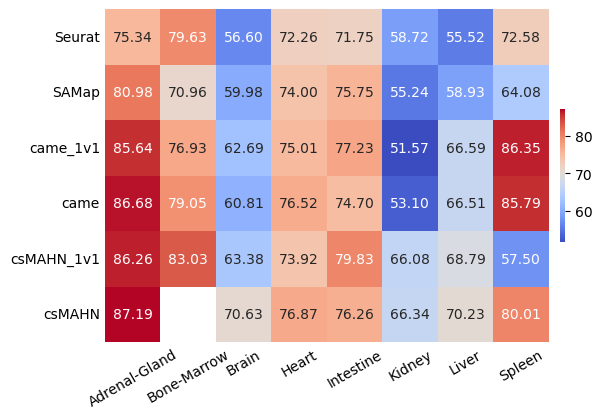

In [7]:
figsize = np.array([1, .618]) * 7
fig, ax = plt.subplots(figsize=figsize)
ax = sns.heatmap(
    data=df_plot,
    ax=ax,
    cmap=cm,
    square=True,
    annot=True,
    fmt=".2f",
    cbar=True,
    cbar_kws={
        'location': 'right',
        # 'orientation':'horizontal',
        'fraction': .1,
        'shrink': .4,
        'aspect': 25,
        'pad': 0.02
    }

)
ax.set_yticklabels(df_plot.index, fontdict={
    'rotation': 0,
})
ax.set_xticklabels(df_plot.columns, fontdict={
    'rotation': 30,
}
)
ax.tick_params(axis='both', length=0)
ax.set(xlabel="", ylabel="")

# ax.set_title(key)
# ax.grid(visible=True)
savefig(fig,
        '{};{};{};h.{}'.format(item, 'heatmap', key, fig_format)
       )

## F1-score

tissue,Adrenal-Gland,Bone-Marrow,Brain,Heart,Intestine,Kidney,Liver,Spleen
model_mask,,,,,,,,
Seurat,75.59%,76.94%,55.49%,70.43%,66.23%,58.99%,55.56%,72.57%
SAMap,81.47%,72.93%,58.37%,74.23%,70.84%,59.21%,59.27%,61.63%
came_1v1,85.01%,74.56%,61.24%,73.50%,72.12%,52.74%,66.35%,85.36%
came,85.94%,76.79%,55.90%,75.98%,69.75%,54.48%,65.90%,85.18%
csMAHN_1v1,85.69%,80.10%,60.45%,69.53%,75.46%,64.66%,67.65%,53.79%
csMAHN,86.48%,nan%,70.59%,75.05%,72.45%,64.79%,68.97%,80.18%


[out][plot] healty_HCL_MCA;heatmap;F1-score;h.png 
	in /public/workspace/licanchengup/link/res_publish/plot


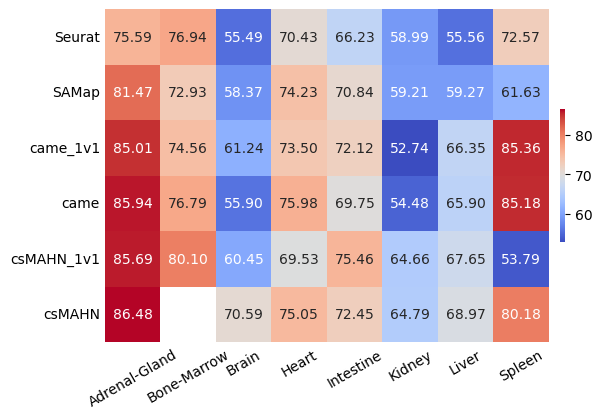

In [8]:
key = 'F1-score'
df_plot =df_h.pivot(values=key,
                   index='model_mask',
                   columns='tissue')
df_plot = df_plot.loc[[i for i in model_masks if i in df_plot.index], :]
df_plot = df_plot.rename(columns=map_sp)
display(
    df_plot.style.highlight_null()
    .set_properties(color='white')
    .background_gradient(cmap=cm, vmin=50, vmax=90)
    .format(lambda x: '{:.2f}%'.format(x))
)
figsize = np.array([1, .618]) * 7
fig, ax = plt.subplots(figsize=figsize)
ax = sns.heatmap(
    data=df_plot,
    ax=ax,
    cmap=cm,
    square=True,
    annot=True,
    fmt=".2f",
    cbar=True,
    cbar_kws={
        'location': 'right',
        # 'orientation':'horizontal',
        'fraction': .1,
        'shrink': .4,
        'aspect': 25,
        'pad': 0.02
    }

)
ax.set_yticklabels(df_plot.index, fontdict={
    'rotation': 0,
})
ax.set_xticklabels(df_plot.columns, fontdict={
    'rotation': 30,
}
)
ax.tick_params(axis='both', length=0)
ax.set(xlabel="", ylabel="")

# ax.set_title(key)
# ax.grid(visible=True)
savefig(fig,
        '{};{};{};h.{}'.format(item, 'heatmap', key, fig_format)
       )

# mouse heatmap

In [9]:
df_m = df.query("sp_ref == 'm'")

# Accuracy

tissue,Adrenal-Gland,Bone-Marrow,Brain,Heart,Intestine,Kidney,Liver,Spleen
model_mask,,,,,,,,
Seurat,56.27%,29.68%,66.43%,71.86%,49.44%,46.84%,75.73%,90.38%
SAMap,70.19%,25.49%,57.51%,72.37%,63.70%,49.27%,67.15%,82.07%
came_1v1,nan%,nan%,nan%,nan%,nan%,55.97%,84.35%,95.77%
came,71.61%,24.79%,51.67%,72.61%,63.53%,48.18%,74.59%,93.32%
csMAHN_1v1,nan%,nan%,nan%,nan%,nan%,54.64%,84.60%,56.28%
csMAHN,72.76%,25.33%,59.44%,72.98%,52.83%,50.10%,83.57%,55.23%


[out][plot] healty_HCL_MCA;heatmap;Accuracy;m.png 
	in /public/workspace/licanchengup/link/res_publish/plot


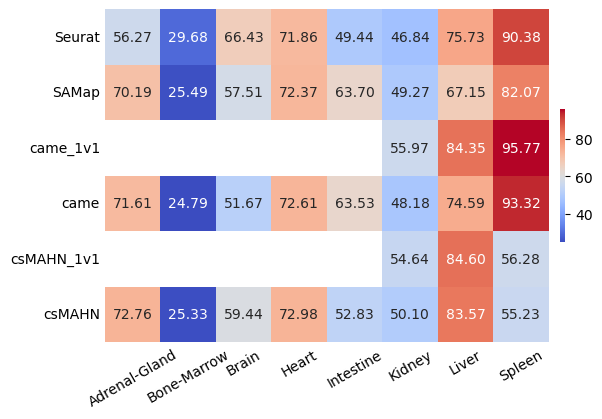

In [10]:
key = 'Accuracy'
df_plot =df_m.pivot(values=key,
                   index='model_mask',
                   columns='tissue')
df_plot = df_plot.loc[[i for i in model_masks if i in df_plot.index], :]
df_plot = df_plot.rename(columns=map_sp)
display(
    df_plot.style.highlight_null()
    .set_properties(color='white')
    .background_gradient(cmap=cm, vmin=50, vmax=90)
    .format(lambda x: '{:.2f}%'.format(x))
)
figsize = np.array([1, .618]) * 7
fig, ax = plt.subplots(figsize=figsize)
ax = sns.heatmap(
    data=df_plot,
    ax=ax,
    cmap=cm,
    square=True,
    annot=True,
    fmt=".2f",
    cbar=True,
    cbar_kws={
        'location': 'right',
        # 'orientation':'horizontal',
        'fraction': .1,
        'shrink': .4,
        'aspect': 25,
        'pad': 0.02
    }

)
ax.set_yticklabels(df_plot.index, fontdict={
    'rotation': 0,
})
ax.set_xticklabels(df_plot.columns, fontdict={
    'rotation': 30,
}
)
ax.tick_params(axis='both', length=0)
ax.set(xlabel="", ylabel="")

# ax.set_title(key)
# ax.grid(visible=True)
savefig(fig,
        '{};{};{};m.{}'.format(item, 'heatmap', key, fig_format)
       )

## F1-score

tissue,Adrenal-Gland,Bone-Marrow,Brain,Heart,Intestine,Kidney,Liver,Spleen
model_mask,,,,,,,,
Seurat,57.09%,29.71%,63.23%,69.89%,52.87%,45.34%,76.69%,91.24%
SAMap,65.30%,24.92%,55.23%,70.77%,63.56%,44.53%,68.81%,86.17%
came_1v1,nan%,nan%,nan%,nan%,nan%,52.91%,83.16%,95.78%
came,66.34%,26.74%,50.74%,69.85%,66.90%,52.20%,77.68%,92.76%
csMAHN_1v1,nan%,nan%,nan%,nan%,nan%,50.50%,82.59%,66.70%
csMAHN,68.86%,27.56%,56.88%,71.77%,56.66%,50.21%,82.11%,65.46%


[out][plot] healty_HCL_MCA;heatmap;F1-score;m.png 
	in /public/workspace/licanchengup/link/res_publish/plot


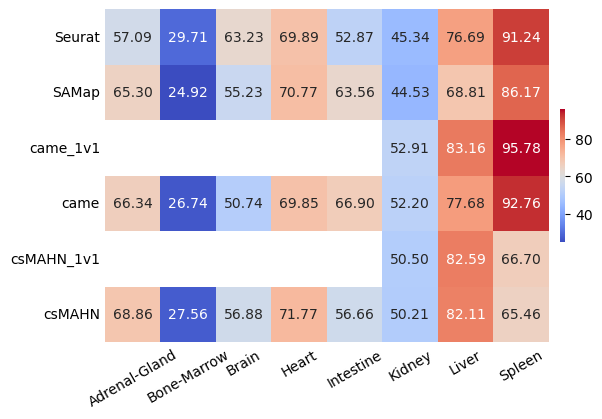

In [11]:
key = 'F1-score'
df_plot =df_m.pivot(values=key,
                   index='model_mask',
                   columns='tissue')
df_plot = df_plot.loc[[i for i in model_masks if i in df_plot.index], :]
df_plot = df_plot.rename(columns=map_sp)
display(
    df_plot.style.highlight_null()
    .set_properties(color='white')
    .background_gradient(cmap=cm, vmin=50, vmax=90)
    .format(lambda x: '{:.2f}%'.format(x))
)
figsize = np.array([1, .618]) * 7
fig, ax = plt.subplots(figsize=figsize)
ax = sns.heatmap(
    data=df_plot,
    ax=ax,
    cmap=cm,
    square=True,
    annot=True,
    fmt=".2f",
    cbar=True,
    cbar_kws={
        'location': 'right',
        # 'orientation':'horizontal',
        'fraction': .1,
        'shrink': .4,
        'aspect': 25,
        'pad': 0.02
    }

)
ax.set_yticklabels(df_plot.index, fontdict={
    'rotation': 0,
})
ax.set_xticklabels(df_plot.columns, fontdict={
    'rotation': 30,
}
)
ax.tick_params(axis='both', length=0)
ax.set(xlabel="", ylabel="")

# ax.set_title(key)
# ax.grid(visible=True)
savefig(fig,
        '{};{};{};m.{}'.format(item, 'heatmap', key, fig_format)
       )